# Importing standard libraries

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

# Seeding values
### This is done so that code values stay uniform

In [ ]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import random
random.seed(42)

# Reading the data into a dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# reading in csv
file_path = '/content/drive/My Drive/DS340/cardio_train.csv'
df = pd.read_csv(file_path, sep=";")

df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


# Data preprocessing

In [ ]:
# renaming some columns to reflect more understandable names
df = df.rename(columns={'ap_hi': 'sys_bp', 'ap_lo': 'dia_bp'})

# dropping the 'id' column as it doesn't provide any value
df = df.drop(columns=['id'])

# making age variable from days to years
df['age'] = df['age'].apply(lambda x: round(x/365,3))

In [ ]:
df.head(10)

,age,gender,height,weight,sys_bp,dia_bp,cholesterol,gluc,smoke,alco,active,cardio
0,50.392,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663,1,165,64.0,130,70,3,1,0,0,0,1
3,48.282,2,169,82.0,150,100,1,1,0,0,1,1
4,47.874,1,156,56.0,100,60,1,1,0,0,0,0
5,60.038,1,151,67.0,120,80,2,2,0,0,0,0
6,60.584,1,157,93.0,130,80,3,1,0,0,1,0
7,61.874,2,178,95.0,130,90,3,3,0,0,1,1
8,48.405,1,158,71.0,110,70,1,1,0,0,1,0
9,54.340,1,164,68.0,110,60,1,1,0,0,0,0


# **Exploratory Data Analysis**

# Distribution of all features

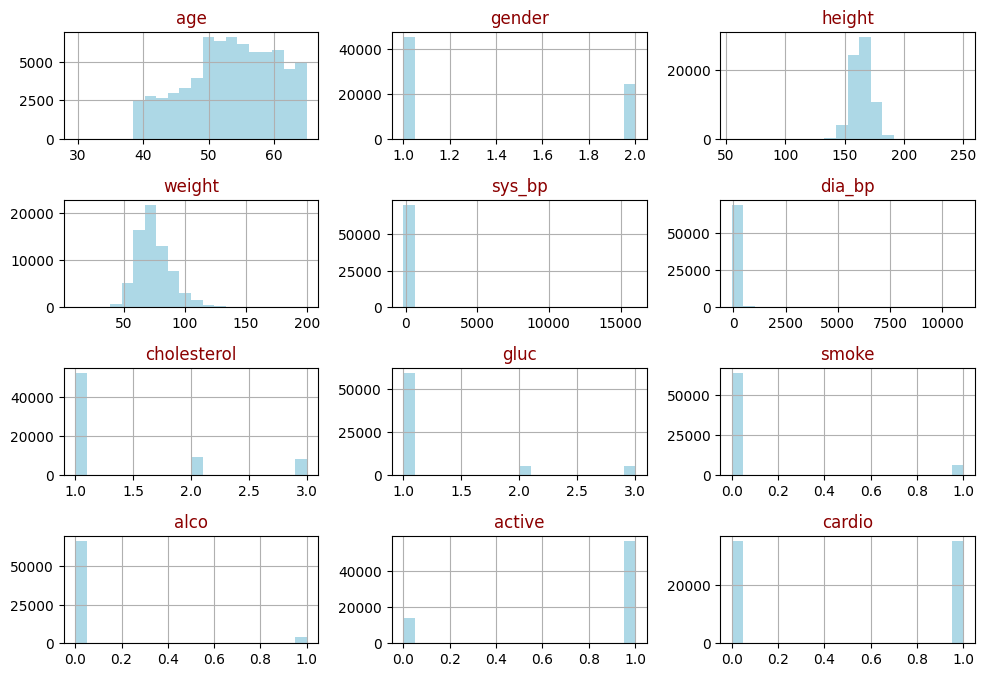

In [ ]:
def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize = (10, 10))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins = 20, ax = ax, facecolor = 'LightBlue')
        ax.set_title(feature, color = 'DarkRed')
    fig.tight_layout()
    plt.show()
draw_histograms(df, df.columns, 6, 3)

*There seems to be some clear outliers, specifically in the sys_bp and dia_bp variables, as you can't have a systolic or dystolic blood pressure over like 400 (highest recorded blood pressure was 370/360). Based on this, we will have to remove some outliers.*

# More data preprocessing
*Here, we remove cases that have an 'impossible' systolic or diastolic blood pressure. We will define our outlier threshold as any cases where the systolic blood pressure or diastolic blood pressure above 250. A reading of 180/120 is defined as a "hypertensive crisis and a medical emergency". The highest blood pressure recording was during an experiment where a male individual recorded a 370/360 blood pressure reading. We believe our threshold eliminates most cases where blood pressure is likely entered incorrectly while still allowing for some extremely high blood pressure ratings in case these actually did occur.*

In [ ]:
bp_outliers = df[(df['sys_bp'] > 250) | (df['dia_bp'] > 250)]
print('Number of patients with a sys_bp or dia_bp > 250:', bp_outliers.shape[0])

bp_outliers[['sys_bp', 'dia_bp']].head(10)

Number of patients with a sys_bp or dia_bp > 250: 993


,sys_bp,dia_bp
228,160,1100
241,160,1000
260,140,800
329,160,1000
345,140,1000
473,150,1033
559,200,1000
613,140,1000
649,190,1100
653,180,1000


In [ ]:
# keeping only cases where sys_bp & dia_bp <= 250
df = df[(df['sys_bp'] <= 250) & (df['dia_bp'] <= 250)]

*There also seem to be some blood pressure values that are 'impossible' on the lower end of the range. A blood pressure of 90/60 is considered to be low blood pressure. Values below 50/60 are considered very dangerous and likely fatal for systolic blood pressure, while anything below 30 for diastolic blood pressure is potentially fatal. Based on this, we will use thresholds of 30 for systolic blood pressure and 10 for diastolic blood pressure to determine 'impossible' values on the lower end of the ranges.*

In [ ]:
bp_outliers = df[(df['sys_bp'] < 30) | (df['dia_bp'] < 10)]
print('Number of patients with a low outlier blood pressure:', bp_outliers.shape[0])
bp_outliers[['sys_bp', 'dia_bp']].head(10)

Number of patients with a low outlier blood pressure: 215


,sys_bp,dia_bp
567,14,90
927,14,90
979,11,80
1600,12,80
1627,14,80
1772,11,60
2014,906,0
2167,14,80
2203,12,80
2431,14,80


In [ ]:
# keeping only cases that fit this criteria
df = df[(df['sys_bp'] >= 30) & (df['dia_bp'] >= 10)]

*Finally, need to remove any instances where the systolic blood pressure is lower than the diastolic blood pressure, as this is not possible.*

In [ ]:
outliers = df[(df['sys_bp'] < df['dia_bp'])]
print('Patients with a systolic blood pressure lower than diastolic blood pressure:', outliers.shape[0])
outliers[['sys_bp', 'dia_bp']].head(10)

Patients with a systolic blood pressure lower than diastolic blood pressure: 1051


,sys_bp,dia_bp
228,160,1100
241,160,1000
260,140,800
329,160,1000
345,140,1000
473,150,1033
474,120,150
559,200,1000
613,140,1000
636,70,110


In [ ]:
# keeping only instances where sys_bp > dia_bp
df = df[(df['sys_bp'] >= df['dia_bp'])]

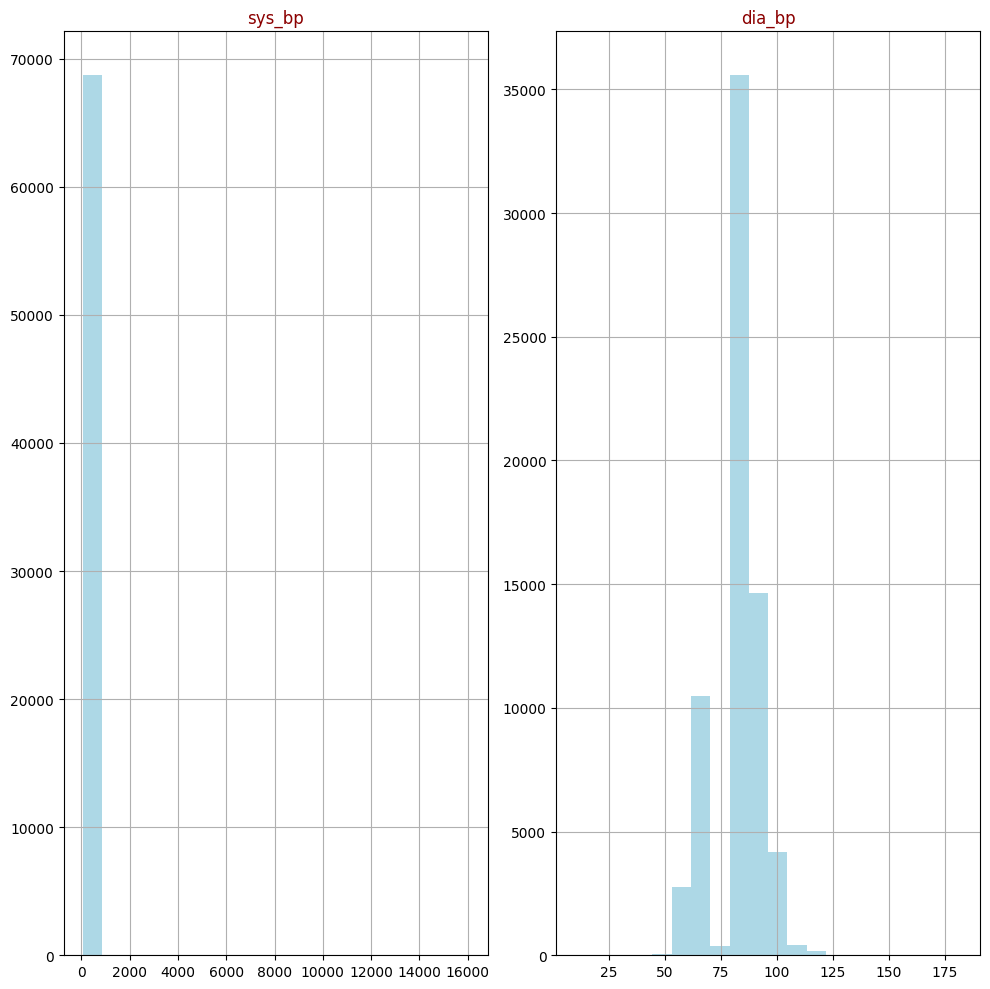

In [ ]:
draw_histograms(df, df[["sys_bp", "dia_bp"]],1,2)

# Creating datasets of only men and only women

In [ ]:
# creating new df and dropping gender columns (don't want it in model)
df_men = df[df['gender'] == 2].drop(columns=['gender'])

df_women = df[df['gender'] == 1].drop(columns=['gender'])

# Gender split analysis

gender
Female    44775
Male      23959
Name: count, dtype: int64


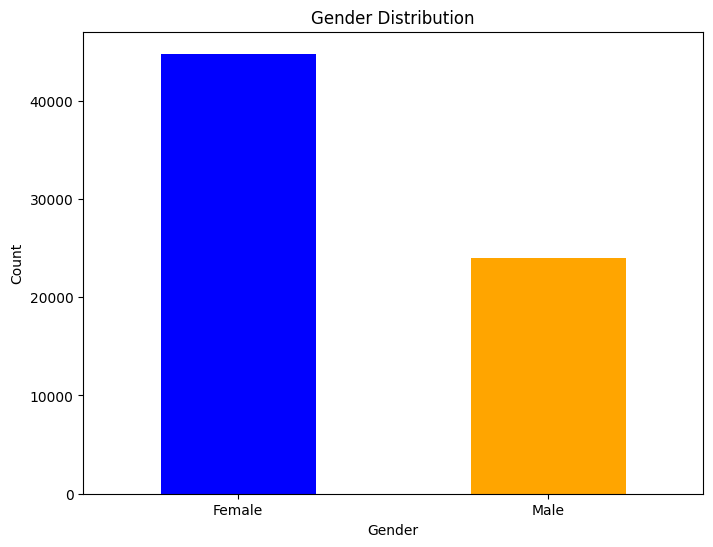

In [ ]:
# getting gender distribution in the dataset
gender_counts = df['gender'].map({1: 'Female', 2: 'Male'}).value_counts()
print(gender_counts)

# Plotting
plt.figure(figsize=(8,6))
gender_counts.plot(kind='bar', color=['blue', 'orange'], )


plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

*From this we can see that the gender split is pretty imbalanced. The difference in heart disease prediction by gender is something we want to investigate, specifically with which features impact a certain gender more than a the other.*

# Target variable distribution analysis

Patients with heart disease: 34013
Patients that don't have heart disease: 34721


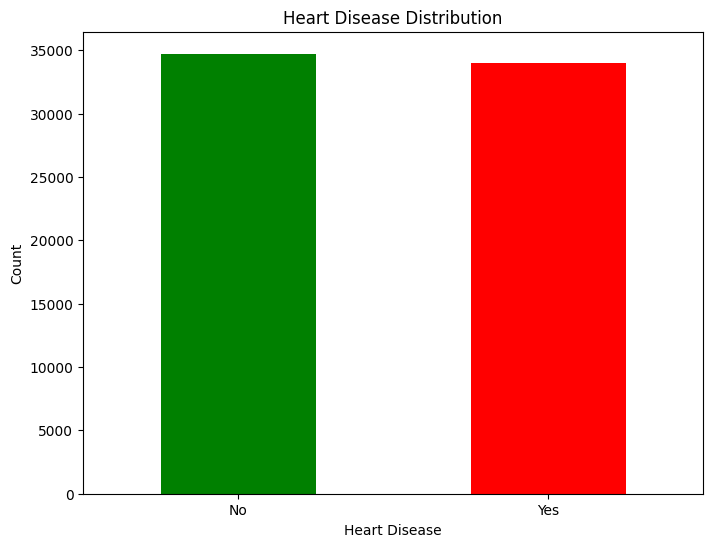

In [ ]:
hd_counts = df['cardio'].map({0: 'No', 1:'Yes'}).value_counts()

print('Patients with heart disease:', hd_counts[1])
print("Patients that don't have heart disease:", hd_counts[0])

hd_counts = hd_counts.reindex(['No', 'Yes'])

# Plotting
plt.figure(figsize=(8,6))
hd_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Heart Disease Distribution')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

*The heart disease target variable in this data set is much more balanced than the data set the authors used previously. This is good as it will help limit potential bias in the model where it could just predict one of the variables for all predictions and still return a high accuracy.*

Patients with heart disease: 11974
Patients that do not have heart disease: 11985


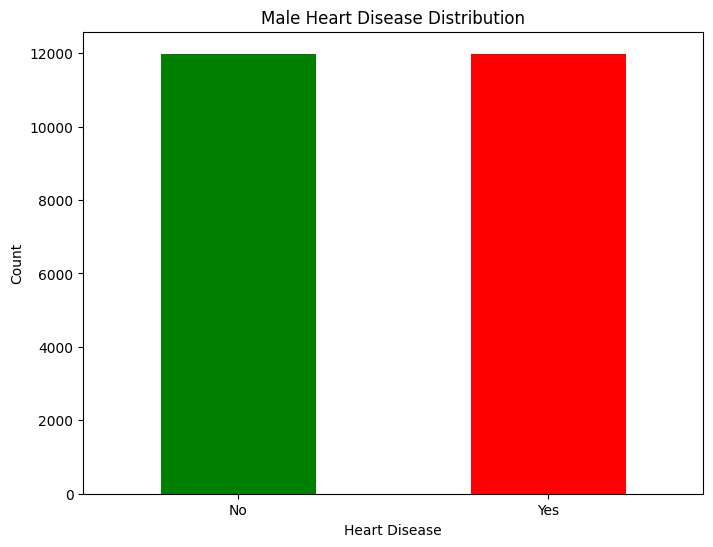

In [ ]:
# heart distribution of males
hd_counts = df_men['cardio'].map({0: 'No', 1: 'Yes'}).value_counts()

print('Patients with heart disease:', hd_counts[1])
print('Patients that do not have heart disease:', hd_counts[0])

# reindexing to ensure placement of categories on x-axis is as desired
hd_counts = hd_counts.reindex(['No', 'Yes'])

# Plotting
plt.figure(figsize=(8,6))
hd_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Male Heart Disease Distribution')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

*This graph shows an even distribution of heart disease amongst males.*

Total patients at risk of CHD:  22039
Total patients not at risk of CHD:  22736


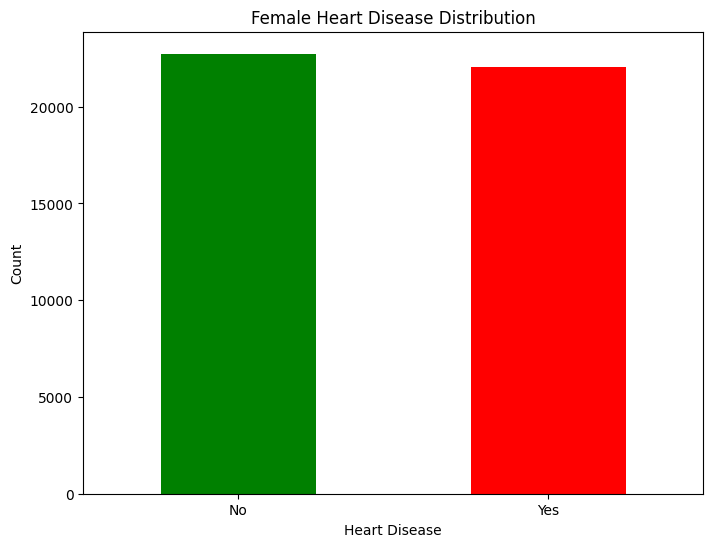

In [ ]:
# heart disease distribution of females
hd_counts = df_women['cardio'].map({0: 'No', 1: 'Yes'}).value_counts()

print('Total patients at risk of CHD: ', hd_counts[1])
print('Total patients not at risk of CHD: ', hd_counts[0])

# reindexing target variable
hd_counts = hd_counts.reindex(['No', 'Yes'])

# Plotting
plt.figure(figsize=(8,6))
hd_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Female Heart Disease Distribution')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks(rotation = 0)

# Display the plot
plt.show()

*This bar chart shows a very even distribution of heart disease amongst females*

# Systolic vs Diastolic Blood Pressure colored by Heart Disease

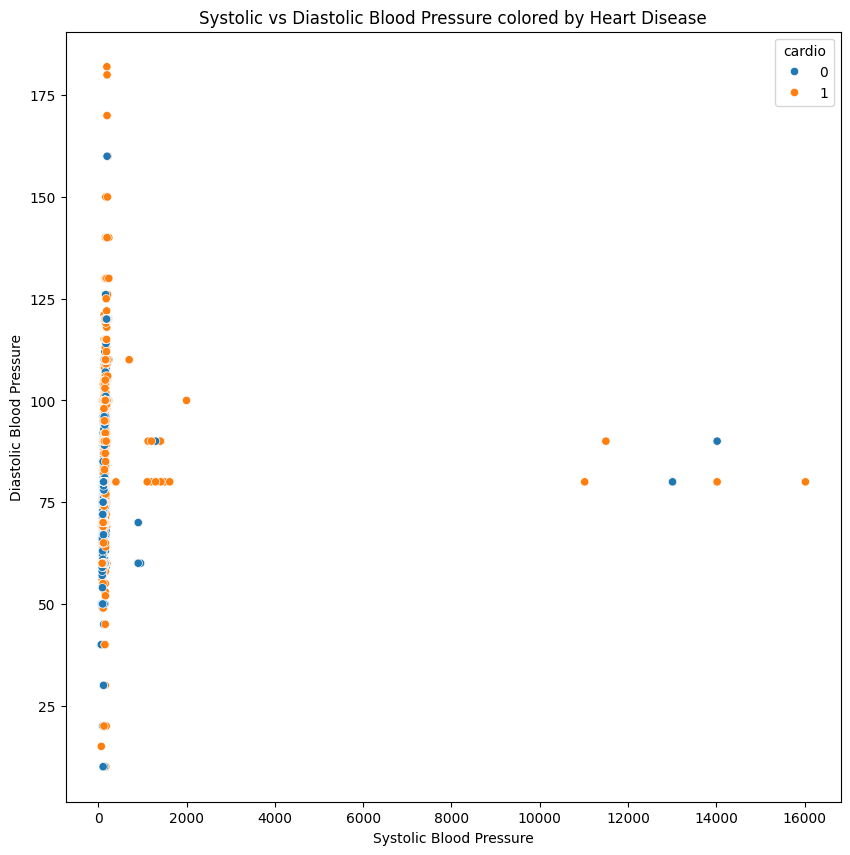

In [ ]:
plt.figure(figsize = (10, 10))
sns.scatterplot(x = 'sys_bp', y = 'dia_bp', hue = 'cardio', data = df)
plt.xlabel('Systolic Blood Pressure')
plt.ylabel('Diastolic Blood Pressure')
plt.title('Systolic vs Diastolic Blood Pressure colored by Heart Disease')
plt.show()

# Correlation plots

**All patients**

Text(0.5, 1.0, 'All Patient Dataframe Correlation Plot')

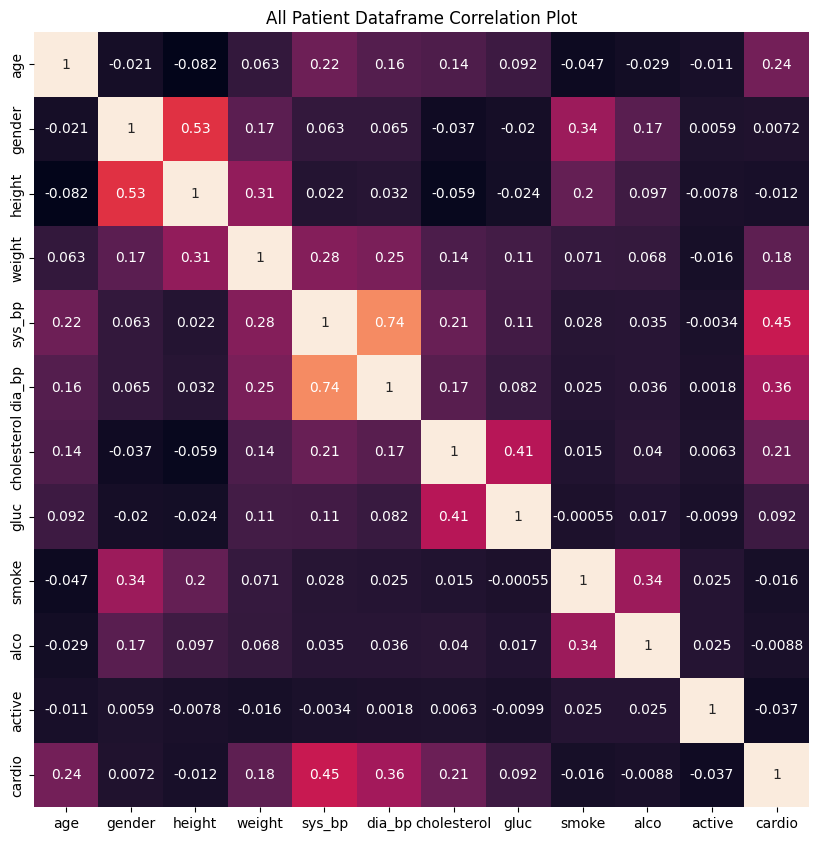

In [ ]:
corr = df.corr(method = 'spearman')

plt.figure(figsize = (10, 16))
sns.heatmap(corr, square = True, cbar = False, annot = True)
plt.title("All Patient Dataframe Correlation Plot")

*There is some significant correlation between systolic and dystolic blood pressure with having cardiovascular disease. This makes sense as blood pressure can be a easy indicator of heart diseases. Gender has very little correlation, which may point to the fact that a certain gender is not more susceptible to having a cardiovascular disease. Through our research we plan to see if this is true and how features impact gender differently.*

Text(0.5, 1.0, 'Men Only Dataframe Correlation Plot')

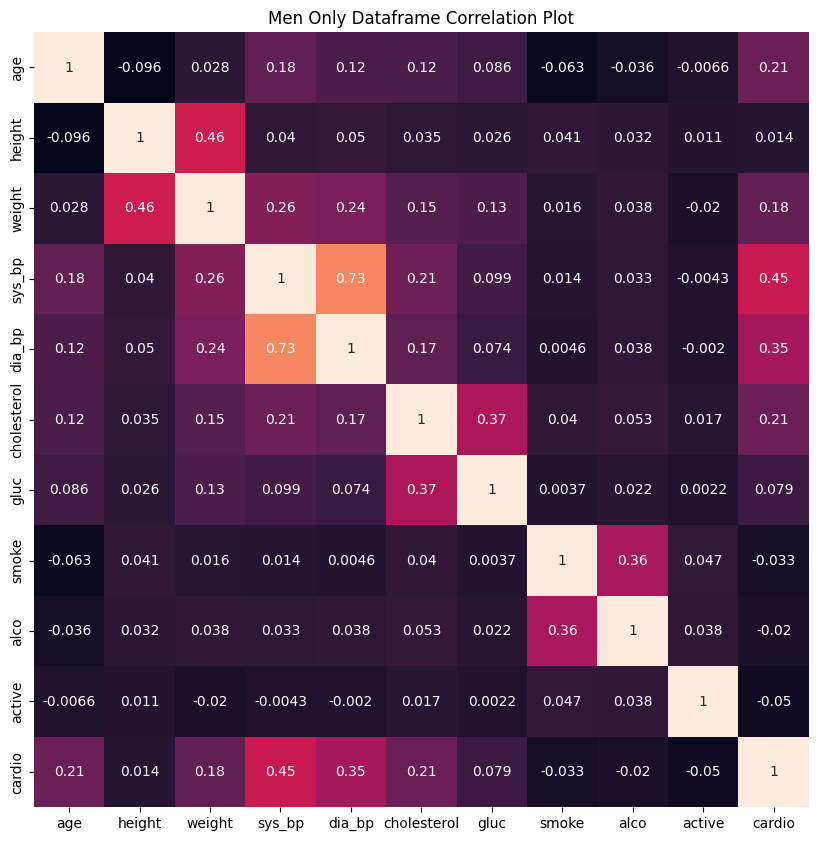

In [ ]:
corr = df_men.corr(method = 'spearman')

plt.figure(figsize = (10, 16))
sns.heatmap(corr, square = True, cbar = False, annot = True)
plt.title("Men Only Dataframe Correlation Plot")

Text(0.5, 1.0, 'Women Only Dataframe Correlation Plot')

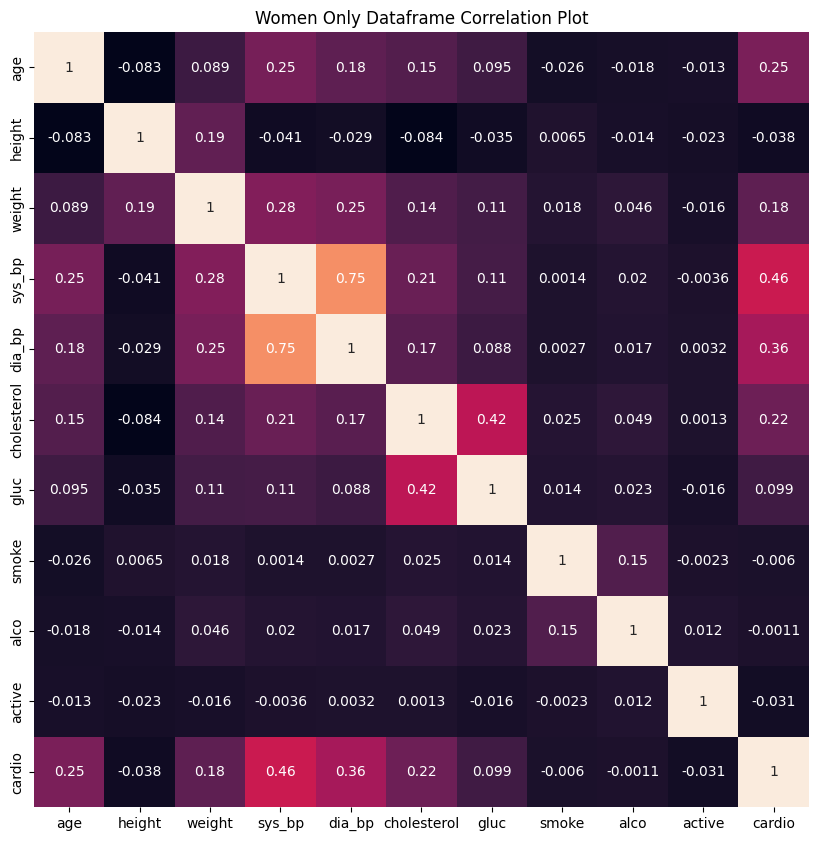

In [ ]:
corr = df_women.corr(method = 'spearman')

plt.figure(figsize = (10, 16))
sns.heatmap(corr, square = True, cbar = False, annot = True)
plt.title("Women Only Dataframe Correlation Plot")

*Comparing the mens vs womens correlation plots, the blood pressure numbers are slightly more correlated with heart disease in women. There were some other small differences in correlation values between variables and the target variable. Alcohol consumption has very little positive correlation (just about zero) with heart disease for women, while it is slightly negative (almost zero too) for men.*

**Missing values**

In [ ]:
print('Missing values: ')
print(df.isnull().sum())

mv = np.array(df.isnull().sum())
ta = 0
for t in mv:
    ta += t
print('\nTotal missing attributes: ', ta)

tr = 0
for i in df.isnull().sum(axis = 1):
    if i > 0:
        tr += 1
print('\nTotal rows with missing data: ', tr)

Missing values: 
age            0
gender         0
height         0
weight         0
sys_bp         0
dia_bp         0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Total missing attributes:  0

Total rows with missing data:  0


*No missing values in the dataset, so no imputation methods will be necessary*

**CONVOLUTIONAL NEURAL NETWORK**

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, ReLU, AveragePooling1D
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import drive

!pip install keras-tuner -q
import keras_tuner
from keras_tuner import RandomSearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


# Model building

### **Getting training, validation and test sets for 'All Patients' dataframe**

In [ ]:
X = df.drop(columns=['cardio']).values
y = df['cardio'].values

# Split the data into training and test sets (80% train, 20% test)
# stratify parameter is used to split dataset into training and testing in way that is proportional to in this case the target_variable
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

# Train-val-test split = 60%, 20%, 20%

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# Reshaping the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Building CNN model based off of CNN structure from paper 2
# had to keep padding as "same" - does not match the paper
# also changed from softmax to sigmoid, as sigmoid is better for binary classification
def build_model(hp):
    model = Sequential()

    # Layer 1: Dense layer w/ 64 neurons, batch normalization, ReLU activation and dropout
    # hyperparameter tuning ==> # of neurons
    model.add(Dense(units = hp.Int('Dense1_neuonrs', min_value = 32, max_value = 512, step = 32),
                    input_shape=(11, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(hp.Float('Dense1_dropout', min_value = 0.1, max_value = 0.5, step = 0.05)))


    # Layer 2: Convolutional layer w/ 2 filters, kernel size of 4, no padding, 2 strides, Batch Normalization, ReLU and average pooling
    model.add(Conv1D(filters=2,
                     kernel_size= 4,
                     strides = 2,
                     padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size=2))


    # Layer 3: Convolutional layer w/ 4 filters, kernel size of 4, no padding, 2 strides, Batch Normalization, ReLU and average pooling
    model.add(Conv1D(filters=4,
                     kernel_size = 6,
                     strides = 2,
                     padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size=2))

    # had to add because of errors
    model.add(Flatten())

    # Layer 4: Dense layer with 512 neurons, Batch normalization, ReLU and dropout
    # Hyperparameter tuning ==> # of neurons
    model.add(Dense(units = hp.Int('Dense2_neurons', min_value = 32, max_value = 512, step = 32)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(hp.Float('Dense2_dropout', min_value = 0.1, max_value = 0.5, step = 0.05)))

    # Layer 5: Dense layer with 1 neuron
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

###**Hyperparameter tuning**

In [ ]:
# Instantiate Keras Tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=3, executions_per_trial=3)


# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model and evaluate on the test set
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test Loss (after tuning): {test_loss}, Test Accuracy (after tuning): {test_acc}')

Trial 3 Complete [00h 03m 08s]
val_accuracy: 0.7199146548906962

Best val_accuracy So Far: 0.7199146548906962
Total elapsed time: 00h 09m 29s
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7146 - loss: 0.5728
Test Loss (after tuning): 0.5609095692634583, Test Accuracy (after tuning): 0.7232123613357544


**Getting best hyperparameters**

In [ ]:
# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Summary of the best model
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 11, 448)             │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 11, 448)             │           1,792 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 11, 448)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 448)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 2)                │           3,586 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 2)                │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 6, 2)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_2                  │ (None, 3, 2)                │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 4)                │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2, 4)                │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 2, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_3                  │ (None, 1, 4)                │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 416)                 │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 416)                 │           1,664 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             417 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 10,511 (41.06 KB)

 Trainable params: 8,771 (34.26 KB)

 Non-trainable params: 1,740 (6.80 KB)

In [ ]:
# Step 8: Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

In [ ]:
# Step 9: Make predictions on the test set
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Step 10: Evaluate performance using various metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Ensemble Learning - bagging

In [ ]:
#BAGGING CODE IS HERE
!pip install scikeras
!pip install --upgrade scikit-learn
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import BaggingClassifier

def build_best_model():
    model = tuner.hypermodel.build(best_hps)
    return model

model = KerasClassifier(build_fn=build_best_model, epochs=20, batch_size=32, verbose=0)

bagging_model = BaggingClassifier(estimator=model, n_estimators=10, random_state=42)
# Flatten X_train for the BaggingClassifier
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Fit bagging with flattened data
bagging_model.fit(X_train_flat, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on the test data
y_pred = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape X_test if needed

# Calculate accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_acc}')

In [ ]:
# Male-only dataset
male_data = df[df['gender'] == 2]
X_male = male_data.drop(columns=['gender', 'cardio'])
y_male = male_data['cardio']
bagging_male = BaggingClassifier(estimator=model, n_estimators=10, random_state=42)

X_male_train_full, X_male_test, y_male_train_full, y_male_test = train_test_split(X_male, y_male, test_size=0.2, random_state=42, stratify=y_male)


X_male_train, X_male_val, y_male_train, y_male_val = train_test_split(X_male_train_full, y_male_train_full, test_size=0.25, random_state=42, stratify=y_male_train_full)

scaler = StandardScaler()
X_male_train = scaler.fit_transform(X_male_train)
X_male_val = scaler.transform(X_male_val)
X_male_test = scaler.transform(X_male_test)

# Reshaping the data
X_male_train = X_male_train.reshape(X_male_train.shape[0], X_male_train.shape[1], 1)
X_male_val = X_male_val.reshape(X_male_val.shape[0], X_male_val.shape[1], 1)
X_male_test = X_male_test.reshape(X_male_test.shape[0], X_male_test.shape[1], 1)

X_male_train_flat = X_male_train.reshape(X_male_train.shape[0], -1)

bagging_male.fit(X_male_train_flat, y_male_train)

In [ ]:
# Female-only dataset
female_data = df[df['gender'] == 1]
X_female = female_data.drop(columns=['gender', 'cardio'])  # Adjust based on columns
y_female = female_data['cardio']
bagging_female = BaggingClassifier(estimator=model, n_estimators=10, random_state=42)
bagging_female.fit(X_female_train, y_female_train)